## Evolutionary Tree Mastery Checkpoint - Joao Cavalcanti

This notebook provides implementation for UPGMA, Neighbor Joining and Small Parsimony algorithms for constructing evolutionary trees. The test cases consists of a distance matrix given in lecture and Rosalind textbook along with screenshots from the book of the expected results for each algorithm. 

### Setup

In [51]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import pandas as pd
import os.path
import copy
import numpy as np
import Assignment7_helper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Test Case - Given in Rosalind Textbook

In [52]:
file = None
locations = ['../data/coronavirus_distance_matrix_additive.txt','../csc-448-student/data/coronavirus_distance_matrix_additive.txt']
for f in locations:
    if os.path.isfile(f):
        file = f
        break
print('Opening',file)
D_sars = pd.read_csv(file,index_col=0)
D_sars

Opening ../csc-448-student/data/coronavirus_distance_matrix_additive.txt


,Cow,Pig,Horse,Mouse,Dog,Cat,Turkey,Civet,Human
Cow,0,295,306,497,1081,1091,1003,956,954
Pig,295,0,309,500,1084,1094,1006,959,957
Horse,306,309,0,489,1073,1083,995,948,946
Mouse,497,500,489,0,1092,1102,1014,967,965
Dog,1081,1084,1073,1092,0,818,1056,1053,1051
Cat,1091,1094,1083,1102,818,0,1066,1063,1061
Turkey,1003,1006,995,1014,1056,1066,0,975,973
Civet,956,959,948,967,1053,1063,975,0,16
Human,954,957,946,965,1051,1061,973,16,0


In [53]:
def show(T, labels=False):
    T = copy.deepcopy(T)
    pos=nx.spring_layout(T)
    nx.draw(T,pos,with_labels=True)
    if labels:
        nx.draw_networkx_labels(T, pos=pos)  

def show_with_weight(T):
    T = copy.deepcopy(T)
    labels = nx.get_edge_attributes(T,'weight')
    max_value = 0
    for n1,n2 in T.edges():
        if T[n1][n2]['weight'] > max_value:
            max_value = T[n1][n2]['weight']
    for n1,n2 in T.edges():
        T[n1][n2]['weight']=max_value - T[n1][n2]['weight'] + 3
    pos=nx.spring_layout(T)
    nx.draw(T,pos,with_labels=True)
    nx.draw_networkx_edge_labels(T,pos,edge_labels=labels);
        

### UPGMA

In [54]:
# UPGMA(D, n)
# Clusters n single-element clusters labeled 1, . . . , n
# construct a graph T with n isolated nodes labeled by single elements 1, . . . , n 
# for every node v in T
#   AGE(v) = 0
# while there is more than one cluster
#   find the two closest clusters Ci and Cj (break ties arbitrarily)
#   merge Ci and Cj into a new cluster Cnew with |Ci| + |Cj| elements
#   add a new node labeled by cluster Cnew to T
#   connect node Cnew to Ci and Cj by directed edges
#   AGE(C) =  DCi,Cj /2
#   remove the rows and columns of D corresponding to Ci and Cj
#   remove Ci and Cj from Clusters
#   add a row/column to D for Cnew by computing D(Cnew, C) for each C in Clusters add Cnew to Clusters
# root = the node in T corresponding to the remaining cluster 
# for each edge (v, w) in T
#   length of (v,w) = AGE(v) - AGE(w) 
# return T

In [55]:
def get_minimum_value(df):
    minimum_distance = np.Inf
    n1 = None
    n2 = None
    for row_name, row in df.iterrows():
        for column_name, distance in row.items():
            if distance != 0 and distance < minimum_distance:
                n1 = row_name
                n2 = column_name
                minimum_distance = distance
    return minimum_distance, n1, n2

def combine_2_columns(df, c1_name, c2_name, new_node):
    new_c = str(c1_name) + ', ' + str(c2_name)
    c1 = df[c1_name]
    c2 = df[c2_name]
    
    # new cluster
    new_c = ((df[c1_name] + df[c2_name])/2).drop(c1_name).drop(c2_name)
    
    # dropping old clusters
    df = df.drop(c1_name, axis=0).drop(c1_name, axis=1)
    df = df.drop(c2_name, axis=0).drop(c2_name, axis=1)
    
    # adding new cluster
    df[new_node] = new_c
    df.loc[new_node] = new_c
    
    return df

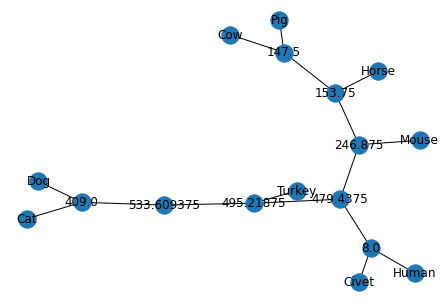

In [56]:
def UPGMA(D, verbose=False):
    num_clusters = len(D.index)
    T = nx.Graph()
    for i in D.index:
        T.add_node(i)
    while num_clusters != 1:
        if verbose:
            print(D)
        
        # finding 2 nearest clusters
        minimum_distance, n1, n2 = get_minimum_value(D)
        
        # combining them into new cluster
        new_node = minimum_distance/2
        T.add_node(new_node)
        T.add_edge(new_node, n1)
        T.add_edge(new_node, n2)
        
        # adding new cluster to table
        D = combine_2_columns(D, n1, n2, new_node)
        
        # remove 2 and add 1 cluster
        num_clusters -= 1
        
        if verbose:
            print(f"minimum_distance: {minimum_distance}, n1, n2")
    
    return T

show(UPGMA(D_sars, verbose=False))

In [57]:
# Expected UPGMA

<img src="./upgma.png" size=500>

### Neighbor Joining

In [58]:
# NEIGHBORJOINING(D, n) 
# if n = 2
#   T the tree consisting of a single edge of length D1,2
#   return T
# D* = the neighbor-joining matrix constructed from the distance matrix D 
# find elements i and j such that D⇤i,j is a minimum non-diagonal element of D
# delta = (TOTALDISTANCED(i) - TOTALDISTANCED(j))/(n - 2)
# limbLengthi = 1/2 (Di,j + delta)
# limbLengthj = 1/2 (Di,j - delta)
# add a new row/column m to D so that Dk,m = Dm,k = 1/2 (Dk,i + Dk,j - Di,j)
# for any k
# remove rows i and j from D
# remove columns i and j from D
# T = NEIGHBORJOINING(D, n - 1)
# add two new limbs (connecting node m with leaves i and j) to the tree T 
# assign length limbLengthi to LIMB(i)
# assign length limbLengthj to LIMB(j)
# return T

In [59]:
def find_minimum_non_diagonal_element(D):
    minimum = np.Inf
    minimum_i = None
    minimum_j = None
    for i in D.index:
        for j in D.columns:
            if i != j and D.loc[i, j] <= minimum:
                minimum = D.loc[i, j]
                minimum_i = i
                minimum_j = j
    return minimum_i, minimum_j

In [60]:
def NEIGHBORJOINING_helper(D, verbose=False):
    D= D.copy()
    n = len(D.index)
    
    # base case
    if n == 2:
        T = nx.Graph()
        T.add_edge(D.index[0], D.index[1], weight=D[D.index[0]][-1])
        return T
    
    # D*
    D_star = D.copy()
    for i in D.index:
        for j in D.columns:
            if i != j:
                D_star.loc[i, j] = (n-2)*D.loc[i, j] - D[i].sum() - D[j].sum() 
            else:
                D_star.loc[i, j] = 0
    
    # minimum non diagonal element
    i, j = find_minimum_non_diagonal_element(D_star)
    
    # delta
    delta = (D[i].sum() - D[j].sum())/(n-2)
    
    # limb lengths
    limbLengthi = (D.loc[i, j] + delta)/2
    limbLengthj = (D.loc[i, j] - delta)/2
    
    if verbose:
        print(f"\ni: {i}, limbLengthi: {limbLengthi}")
        print(f"j: {j}, limbLengthj: {limbLengthj}")
        
    
    # add a new row/column m to D
    m = pd.Series(dtype='float64')
    m_name = i + ',' + j
    for k in D.index:
        m[k] = (D.loc[k, i] + D.loc[k, j] - D.loc[i, j])/2
    D[m_name] = m
    D.loc[m_name] = m
    
    # remove rows/columns i and j from D
    
    D = D.drop(i, axis=0).drop(i, axis=1)
    D = D.drop(j, axis=0).drop(j, axis=1)
    
    D.fillna(0, inplace=True)
    
    # recursive call
    T = NEIGHBORJOINING_helper(D, verbose=verbose)
    
    # add two new limbs (connecting node m with leaves i and j) to the tree T 
    T.add_edge(m_name, i, weight=limbLengthi)
    T.add_edge(m_name, j, weight=limbLengthj)
    
    return T

def NEIGHBORJOINING(D, verbose=False):
    T = NEIGHBORJOINING_helper(D, verbose=verbose)
    
    # renaming internal nodes for visibility
    mapping = {}
    count = 0
    for node in T.nodes():
        if ',' in node:
            count += 1
            mapping[node] = f"m{count}"
    T = nx.relabel_nodes(T, mapping)
    
    return T

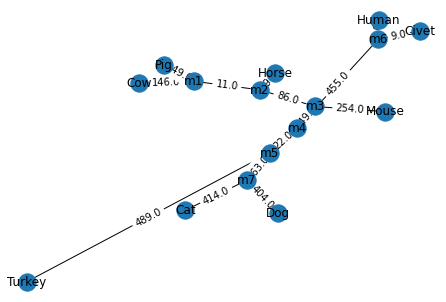

In [61]:
show_with_weight(NEIGHBORJOINING(D_sars))

In [62]:
# Expected Neighbor Joining

<img src="./neighborjoining.png" size=500>

### Small Parsimony

In [63]:
# SMALLPARSIMONY(T, CHARACTER) 
#  for each node v in tree T
#    TAG(v) = 0 
#    if v is a leaf
#      TAG(v) = 1
#      for each symbol k in the alphabet
#          if CHARACTER(v) = k 
#            sk(v) = 0
#          else
#            sk(v) = inf
#  while there exist ripe nodes in T
#    v a ripe node in T
#    TAG(v) = 1
#    for each symbol k in the alphabet
#    sk(v) = min {si(DAUGHTER(v)) + di,k} + min{sj(SON(v)) + dj,k}
#           all symbols i                   all symbols j
#  return min sk (v) all symbols k

In [64]:
def get_ripe_nodes(t, tag):
    for v in t.nodes():
        if t.out_degree(v) != 0 and tag[v] == 0:
            children = list(t.successors(v))
            if tag[children[0]] == 1 and tag[children[1]] == 1:
                return v, children[0], children[1]
    return None, None, None

In [65]:
def SMALLPARSIMONY(t, character):
    tag = {}
    alphabet = ['A', 'T', 'C', 'G']
    s = {}
    # creating matrix
    for v in t.nodes():
        s[v] = {}
        for k in alphabet:
            s[v][k] = 0
    
    # initiating tree with base conditions
    for v in t.nodes():
        tag[v] = 0
        
        # leaf node
        if t.out_degree(v) == 0:
            tag[v] = 1
            for k in alphabet:
                if character[v] == k:
                    s[v][k] = 0
                else:
                    s[v][k] = np.Inf
                    
    ripe_node, daughter_node, son_node = get_ripe_nodes(t, tag)
    
    # while there are still ripe nodes
    while ripe_node:
        tag[ripe_node] = 1
        for k in alphabet:
            minimum = np.Inf
            for i in alphabet:
                for j in alphabet:
                    daughter = s[daughter_node][i] + 1 if i == k else s[daughter][i]
                    son = s[son_node][j] + 1 if j == k else s[son_node][j]
                    score = daughter + son 
                    if score < minimum:
                        minimum = score
            s[v][k] = score
        ripe_node, daughter_node, son_node = get_ripe_nodes(t, tag)
    
    # return root's minimum
    return min(s['root'].values())

### Comparison

* The small parsimony algorithm relies on a dynamic programming approach to find the lowest weighted tree when already given an evolutionary tree. Even though small parsimony requires a tree as an input, this algorithm is important because it is a better grounded method of comparing organisms based on nucleotide differences (mutations) to construct a phylogeny when compared to older methods that relied on anatomical characteristics.
* UPGMA and Neighbor Joining, however, do create an evolutionary tree when given a distance matrix. The most noticeable distinction is that the former labels limb nodes (speciaziation events) with distances, while the latter labels the edges with distances. The benefit of UPGMA is that is also able to analyze non-additive matrices as opposed to the Additive Phylogeny and Neighbor Joining algorithms. 